## Inference 

In this notebook we will test out the pretrained model. Check out how its performing, where it is looking at the image and we will try to confuse it to see its limits. Some of the initial stuff is pretty much same with the training notebook so we will skip explanation.

In [ ]:
!pip install transformers 

In [2]:
import json

with open('kaggle.json') as f:
  kaggle_dictionary = json.load(f)

In [3]:
import os
os.environ['KAGGLE_USERNAME'] = kaggle_dictionary["username"]
os.environ['KAGGLE_KEY'] = kaggle_dictionary["key"]

In [4]:
!kaggle datasets download -d adityajn105/flickr8k # download flicker8k dataset

100% 1.04G/1.04G [00:31<00:00, 32.7MB/s]
100% 1.04G/1.04G [00:31<00:00, 35.7MB/s]


In [5]:
!unzip -q flickr8k.zip 

In [6]:
!kaggle datasets download -d begum302553/tasviret-flickr8k-turkish #download TasvirEt caption dataset

100% 946k/946k [00:00<00:00, 1.88MB/s]
100% 946k/946k [00:00<00:00, 1.88MB/s]


In [7]:
!unzip -q tasviret-flickr8k-turkish.zip 

In [8]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from PIL import Image
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

In [9]:
data = pd.read_json("tasviret8k_captions.json")

In [10]:
data.head()

images   dataset
0  {'split': 'train', 'filename': '2513260012_03d...  flickr8k
1  {'split': 'train', 'filename': '2903617548_d3e...  flickr8k
2  {'split': 'train', 'filename': '3338291921_fe7...  flickr8k
3  {'split': 'train', 'filename': '488416045_1c6d...  flickr8k
4  {'split': 'train', 'filename': '2644326817_8f4...  flickr8k

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.image_encoder = models.resnet18()
        self.image_encoder.fc = nn.Identity()
        
        self.image_out = nn.Sequential(
            nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 256)
        )

        self.text_encoder = AutoModel.from_pretrained("dbmdz/distilbert-base-turkish-cased")
        self.target_token_idx = 0


        self.text_out = nn.Sequential(
            nn.Linear(768, 256), nn.ReLU(), nn.Linear(256, 256)
        )
      

    def forward(self, image, text, mask):

        image_vec = self.image_encoder(image)
        
        image_vec = self.image_out(image_vec.view(-1,512))

        text_out = self.text_encoder(text, mask)
        last_hidden_states = text_out.last_hidden_state

        last_hidden_states = last_hidden_states[:,self.target_token_idx,:]

        text_vec = self.text_out(last_hidden_states.view(-1,768))

        return image_vec, text_vec

In [12]:
model = Net()

Some weights of the model checkpoint at dbmdz/distilbert-base-turkish-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Download pretrained model from huggingface repo

In [16]:
!git clone https://huggingface.co/kesimeg/turkish-clip

Cloning into 'turkish-clip'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 18 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), 3.02 KiB | 515.00 KiB/s, done.


In [17]:
model.load_state_dict(torch.load("turkish-clip/clip_model.pt", map_location=torch.device('cpu')))
model.eval()

Net(
  (image_encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [18]:
transform=transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
],
)

In [19]:
tokenizer = AutoTokenizer.from_pretrained("dbmdz/distilbert-base-turkish-cased")



def load_image(id,saliency=False):
  val_set = data[7000:]
  file_name = val_set["images"].values[id]["filename"]
  if saliency == False:
    captions = val_set["images"].values[id]["sentences"]
    for (i,caption) in zip(range(len(captions)),captions):
      print("Caption {}: ".format(i),caption["raw"])
  
  img = Image.open("./Images/{}".format(file_name))
  if saliency == False:
    plt.imshow(img)
    plt.show()
  return img
  
def predict(img,text_vec):
  input = transform(img).unsqueeze(0)
  token_list = tokenizer(text_vec,padding = True)

  text = torch.Tensor(token_list["input_ids"]).long()
  mask = torch.Tensor(token_list["attention_mask"]).long()


  image_vec, text_vec = model(input, text , mask) 
  print(F.softmax(torch.matmul(image_vec,text_vec.T),dim=1))

To see where the model is looking at we will use saliency gradient method. This method basically shows the regions which triggers the model to give its final output values. We add random noise to our image and repeat this process many times and take the average of the gradients in order to get smoother output. 

In [20]:
def random_noise(image,sigma_multiplier):
  noise = torch.rand_like(image)


  mean = 0
  sigma = sigma_multiplier / (torch.max(image) - torch.min(image)).item()

  noise = noise.normal_(mean,sigma**2)

  return image+noise

In [22]:
def compute_saliency_map(image_id,text_list,num_loop = 50):
  grad_img = torch.zeros(1,224,224)

  sigma_multiplier = 4

  img = load_image(image_id,True)
  criterion = nn.CrossEntropyLoss()
  token_list = tokenizer(text_list,padding = True)
  text = torch.Tensor(token_list["input_ids"]).long()
  mask = torch.Tensor(token_list["attention_mask"]).long()

  for i in tqdm(range(0,num_loop)):
      
      input = transform(img).unsqueeze(0)
    
      image_copy = input.clone()
      image_copy = random_noise(image_copy,sigma_multiplier)
      image_copy.requires_grad=True

      
      image_vec, text_vec = model(image_copy, text , mask) 

      output = torch.matmul(image_vec,text_vec.T)
      predict = torch.softmax(output,1)

      class_num = 1
      label=torch.tensor([class_num])

      maxim,index = torch.max(predict,1)
      output_max = output[:,index]
      output_max.backward()

      grad = image_copy.grad
      grad = torch.abs(grad)
      grad,_= torch.max(grad,dim=1)
      grad_img+=grad
  grad_img=grad_img/num_loop

  grad_img_norm = (grad_img - grad_img.min()) / (grad_img.max() - grad_img.min())
  resized_img = img.resize((224,224))
  grad_multiplied_img = torch.Tensor(np.array(resized_img)) * grad_img_norm.permute(1,2,0) / 255

  f, axarr = plt.subplots(1,3, figsize=(16, 16))
  axarr[0].imshow(resized_img)
  axarr[1].imshow(grad_img.squeeze(0),cmap = "inferno")
  axarr[2].imshow(grad_multiplied_img)

  return grad_img

Caption 0:  Üç köpek kameraya doğru koşuyorlar.
Caption 1:  Bir köşesinde sulak bir kısmın bulunduğu bir çayırda koşan üç köpek.


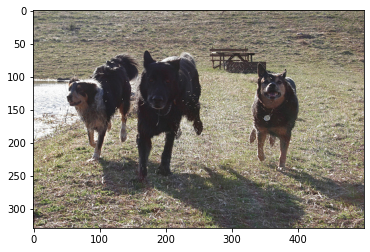

In [60]:
img = load_image(100)

In [52]:
text_list = ["Koşan iki köpek.","Koşan üç köpek.","Koşan dört köpek."] # Two running dogs, Three running dogs, Four running dogs 
predict(img,text_list)

tensor([[0.1447, 0.4742, 0.3811]], grad_fn=<SoftmaxBackward0>)


These three sentences above are fed into the model to be compared. It can be seen that the model gives higher probability to three dogs which shows that the model can count. In the images below you see the original image, heatmap of gradients or saliency map and finally important regions highlighted in the last image. You can see that the model focuses on the dogs.

100%|██████████| 50/50 [00:31<00:00,  1.58it/s]


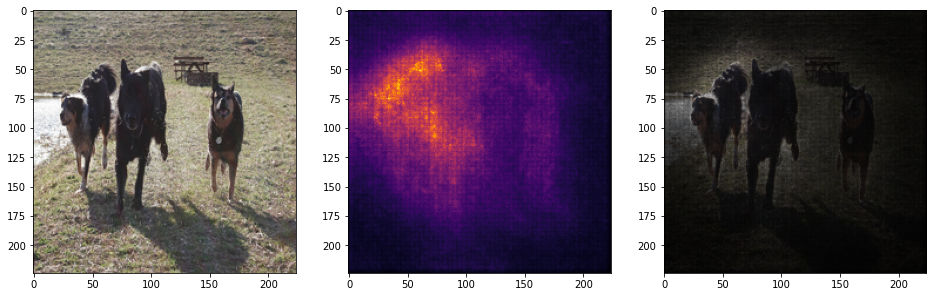

In [53]:
saliency = compute_saliency_map(100,text_list)

Caption 0:  Gün batımında sahilde oyun oynayan iki erkek çocuğu.
Caption 1:  İki çocuk güneş ufuktayken bir sahilde birlikte oyun oynuyorlar.


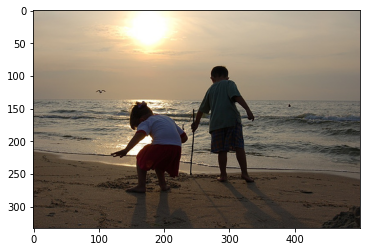

In [26]:
img = load_image(400)

In [27]:
text_list = ["Gün batımında kumla oynayan iki çocuk.","Gece kumla oynayan iki çocuk.","Kumla oynayan üç çocuk."]
# Two kids playing with sand during sun set, Two kids playing with sand at night, Three kids playing with sand
predict(img,text_list)

tensor([[0.6866, 0.2525, 0.0609]], grad_fn=<SoftmaxBackward0>)


Looking at the example above the model can understand the difference between sun set and night. This implies that the model has an understanding or time or at least the position of the sun.

100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


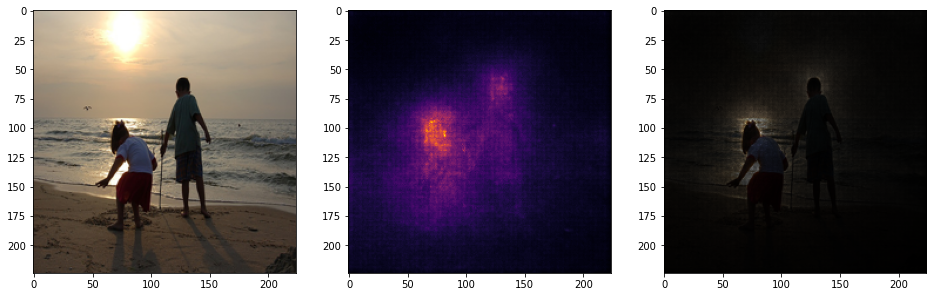

In [28]:
saliency = compute_saliency_map(400,text_list)

Caption 0:  İki kız çocuğu futbol oynuyor.
Caption 1:  Çimlerde antreman yapan genç kızlar.


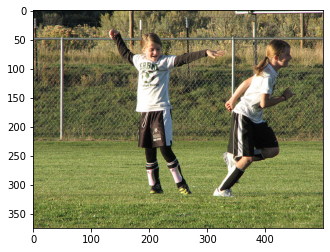

In [30]:
img = load_image(500)

In [31]:
text_list = ["İki oğlan çocuğu futbol oynuyor.","İki kız çocuğu futbol oynuyor."]
#Two boys are playing football, Two girls are playing football
predict(img,text_list)

tensor([[0.4366, 0.5634]], grad_fn=<SoftmaxBackward0>)


The model can also distinguish gender

100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


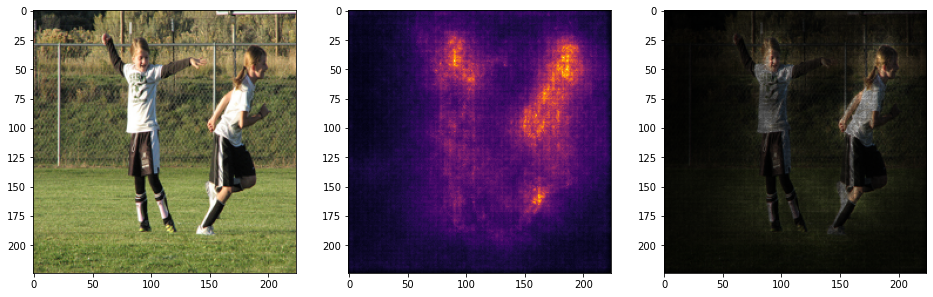

In [32]:
saliency = compute_saliency_map(500,text_list)

Caption 0:  Mavi tişörtlü bir çocuk kaykay yapıyor.
Caption 1:  Kaykaylı bir adam sokakta kayarken.


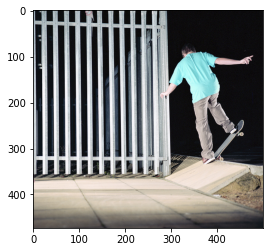

In [33]:
img = load_image(600)

In [34]:
text_list = ["Mavi tişörtlü bir kaykaycı.","Sarı tişörtlü bir kaykaycı.","Kırmızı tişörtlü bir kaykaycı."]
# A skateboarder with a blue t-shirt, A skateboarder with a yellow t-shirt, A skateboarder with a red t-shirt
predict(img,text_list)

tensor([[0.3440, 0.2990, 0.3570]], grad_fn=<SoftmaxBackward0>)


The model can not really understand the color. One of the the actual captions contain the phrase "Blue t-shirt" however it seems that the model does not pay attention to this.

In [35]:
text_list = ["Mavi tişörtlü bir çocuk kaykay yapıyor.","Sarı tişörtlü bir çocuk kaykay yapıyor.","Kırmızı tişörtlü bir çocuk kaykay yapıyor."]
predict(img,text_list)

tensor([[0.3368, 0.3042, 0.3590]], grad_fn=<SoftmaxBackward0>)


To check if the wording effects the output the original caption is used with different colours however it does not seem to change the result.

100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


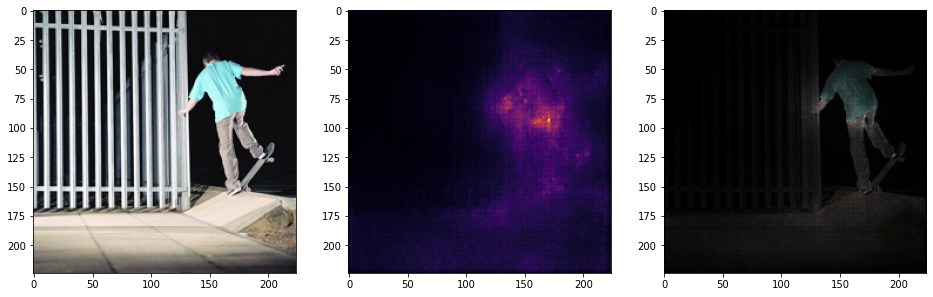

In [36]:
saliency = compute_saliency_map(600,text_list)

Caption 0:  Şelaleden akan su içinde dolaşan kız.
Caption 1:  Bir kız şelanin önünde sularda yürüyor.


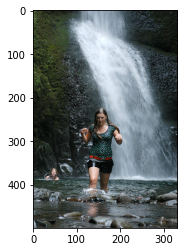

In [56]:
img = load_image(950)

In [59]:
text_list = ["Şelaleden su akıyor.","Şelaleden ateş akıyor."] 
# Water flows from the waterfall, Flame flows from the waterfall.
predict(img,text_list)

tensor([[0.7723, 0.2277]], grad_fn=<SoftmaxBackward0>)


The original captioning is "Girl wandering in the water flowing from the waterfall." Altough the girl is not mentioned in the sample above it seems that the model is not confused. It is unlikely for flame to fall from waterfall but the important point here is that the model not getting confused altough the girl is not mentioned. 

100%|██████████| 50/50 [00:30<00:00,  1.63it/s]


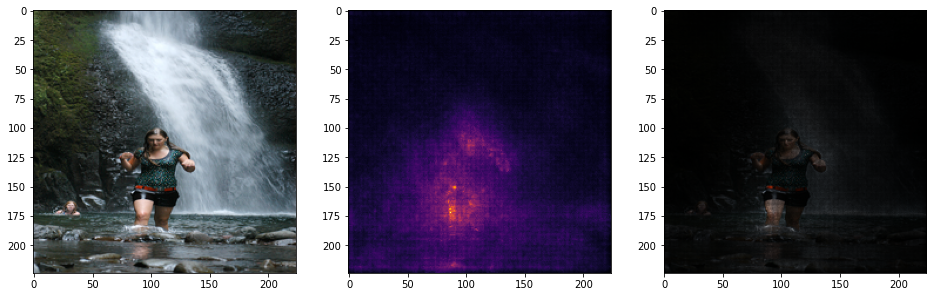

In [39]:
saliency = compute_saliency_map(950,text_list)

Caption 0:  Faleze tırmanan dağcı.
Caption 1:  İp ile kayalıklardan aşağıya inen sporcu.


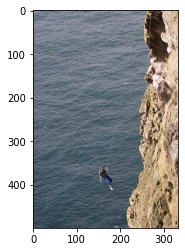

In [40]:
img = load_image(101)

In [41]:
text_list = ["Tırmanış yapan bir dağcı.","Denize iple sarkan bir yüzücü."]
# A climbing climber., A swimmer hanging to the sea with a rope. (The first  sentence makes sense in turkish :D)
predict(img,text_list)

tensor([[0.9342, 0.0658]], grad_fn=<SoftmaxBackward0>)


In this example I tried to give a confusing caption. The second caption could confuse the model because there is a sea in the photo. The model could have easily thought the person is a swimmer. Also the hanging with a rope part is true which could have also confused the model. It seems that these were not enough to confuse the model.

100%|██████████| 50/50 [00:31<00:00,  1.57it/s]


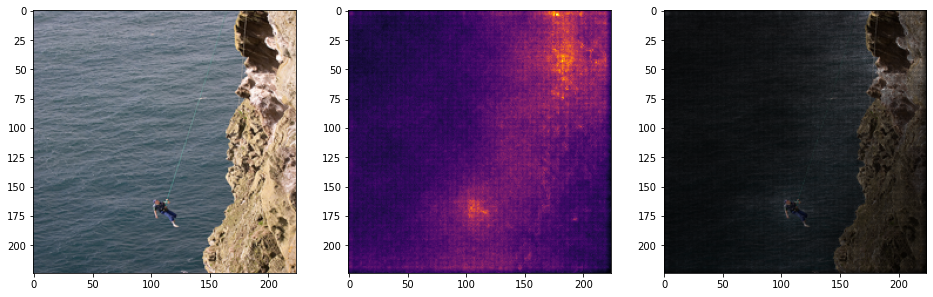

In [42]:
saliency = compute_saliency_map(101,text_list)

Caption 0:  Bir kadın ragbi takımı oyuncuları havadaki ragbi topunu yakalamaya çalışıyor.
Caption 1:  Havaya sıçrayarak topu kapmaya çalışan kadın ragbi oyuncuları.


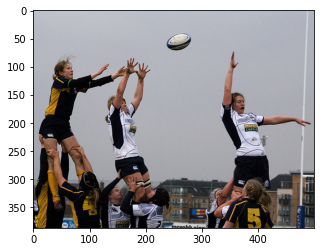

In [43]:
img = load_image(102)

In [44]:
text_list = ["Kadın voleybol takımı.","Kadın ragbi takımı."]
# Woman voleyball team. Woman rugby team.
predict(img,text_list)

tensor([[0.9337, 0.0663]], grad_fn=<SoftmaxBackward0>)


The first time I looked at the image I thought it was a voleyball match. Then  I checked the caption and realised that it was actually a rugby team. So I thought voleyball could confuse the model and the results show that it actually does. A possible reason can be the resizing of the images. The only possible way to understand that this is a rugby match and not a voleyball match is to look at the shape of the ball. The original image is a rectangular image. When it is resized to 224x224 it becomes a square shaped image and the width/height ratio is not preserved. This means that the image is streched and the shape of the ball is altered. This might be possible reason that can confuse the model. This might be solved preserving the height widht ration when resizing and then taking square crops from the image. Since we preserve the ratio the image would not be stretched.

100%|██████████| 50/50 [00:31<00:00,  1.59it/s]


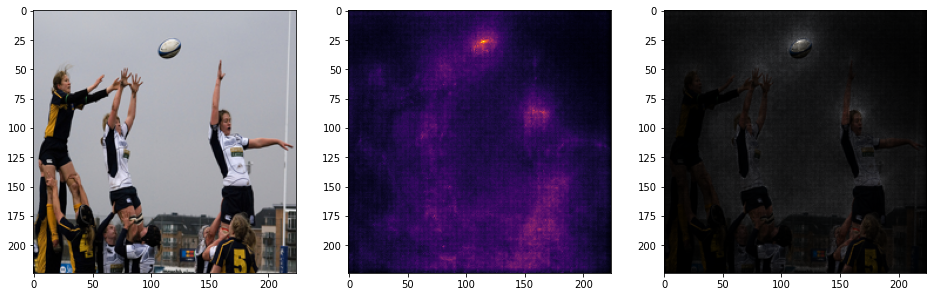

In [45]:
saliency = compute_saliency_map(102,text_list)